In [ ]:
import json
import os
import random
import sys
import pickle
from PIL import Image

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from numpy import asarray
import jax.numpy as jnp
import jax
from jax import jit
from jax import random

In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-uvg1sk8h
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-uvg1sk8h
  Created wheel for dm-haiku: filename=dm_haiku-0.0.7.dev0-py3-none-any.whl size=588956 sha256=396d56407dae177ab6056621213385640c8c5e578e3bbc638d1f1407e18d0900
  Stored in directory: /tmp/pip-ephem-wheel-cache-sa6eb560/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku


In [ ]:
import haiku as hk

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/Capstone Project/Dependencies')

In [ ]:
import transferlearningresnet as resnetModel
import bi_lstm_fashion
from embeddinggeneration import embeddingGenerator
from outfitprocessing import wordDictionary

In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/Capstone Project/'

**PARAMETERS LOADING**

In [ ]:
param_path = os.path.join(path, 'params.p')
# param_path = '/content/gdrive/MyDrive/Colab Notebooks/Capstone Project/params.p'

params = pickle.load( open( param_path, "rb" ) )
params.keys()
# old Params --> dict_keys(['linear', 'lstm/linear', 'lstm_1/linear', 'mlp/~/linear_0', 'mlp_1/~/linear_0', 'visual_semantic'])

dict_keys(['linear', 'linear_1', 'linear_2', 'lstm/linear', 'lstm_1/linear', 'visual_semantic'])

In [ ]:
params['visual_semantic'].keys()

dict_keys(['ws', 'wv'])

**TEST FEATURES LOADING**

In [ ]:
test_features_path = os.path.join(path, 'test_features.p')

test_features = pickle.load( open(test_features_path, "rb" ) )
image_names,image_RNNs,image_visualSemantics = test_features
len(image_names), type(image_names), image_RNNs.shape, image_visualSemantics.shape, type(image_RNNs)

(14, list, (14, 512), (14, 512), numpy.ndarray)

In [ ]:
image_RNNs_stack =  np.vstack((image_RNNs, np.zeros(image_RNNs.shape[1])))
embedding_features = image_names,image_RNNs_stack,image_visualSemantics

In [ ]:
outfitImages_path = os.path.join(path, 'Polyvore_Data/Outfits')

**QUERY**

In [ ]:
query_file = os.path.join(path, 'query.json')
query_sets = json.load(open(query_file))

In [ ]:
input_path = query_sets['image_directory']

**IMAGES EXTRACTION**

In [ ]:
def input_images(jsonObj):
  input_path = jsonObj['image_directory']
  imgIDs = jsonObj['image_query']
  images = []
  for id in imgIDs:
    image_path = os.path.join(input_path, str(id) + '.jpg')
    image = Image.open(image_path)
    # print(image.format, image.size)
    images.append(image)
    # print(image_path)

  return images

In [ ]:
images = input_images(query_sets)

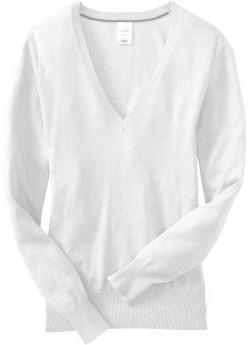

In [ ]:
images[0]

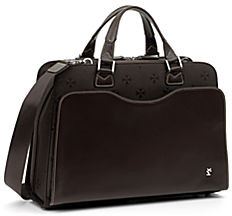

In [ ]:
images[1]

**CAPTION EXTRACTION**

In [ ]:
# caption_query = query_sets['text_query']
# caption_query = 'bag jacket dheheh rgrbtthth coat'
caption_query = 'bag jacket dheheh rgrbtthth coat denim'

**WORD DICTIONARY GENERATION**

In [ ]:
dict_path = os.path.join(path, 'Polyvore_Data/final_word_dict.txt')
wordDic = wordDictionary(dict_path)

**RESNET MODEL INITIALIZATION**

In [ ]:
imgSize = (224,224,3)
modelResnet = resnetModel.getResNetModel(imgSize)

94781440/94765736 [==============================] - 1s 0us/step


**OUTFIT PREDICTION**

--> PREDICTION LOGIC

In [ ]:
def captionProcessing(caption, tokenDic):

  dict_len = len(tokenDic)

  def oneHotEncoding(tokenIds, vectorLength):
    zeroVector = [0]*vectorLength
    oneHotVectors = [zeroVector[:i]+[1]+zeroVector[i+1:] for i in tokenIds]
    oneHotVectorsArray = np.array(oneHotVectors, dtype=jnp.float32)
    return oneHotVectorsArray

  token_ids = [tokenDic.get(word, dict_len) for word in caption.split()]
  if not(len(token_ids)):
    token_ids = [dict_len]
  oneHotVectors = oneHotEncoding(token_ids, dict_len+1)
  oneHotEmbedding = np.sum(oneHotVectors, axis=0)
  oneHotEmbedding[-1] = 0 
  return jnp.array(oneHotEmbedding, dtype=jnp.float32)

In [ ]:
def unit(M):
  M_norm = jnp.reshape(jnp.linalg.norm(M, axis=1), (-1,1))
  return M/M_norm

In [ ]:
def run_RNN(rnn_cell_model, input_feed, test_feat, params_LSTM):

  logits, state = rnn_cell_model.apply(params_LSTM, input_feed, None)

  res_set = []
  
  while True:

    if len(res_set) >= 3:
      break

    curr_score = jnp.exp(jnp.dot(test_feat, logits.reshape(-1)))
    curr_score /= jnp.sum(curr_score)

    sorted_args = jnp.argsort(curr_score)[::-1].tolist()

    for exclusion in res_set:
      sorted_args.remove(exclusion)

    if not(len(sorted_args)):
      break

    next_image = sorted_args[0]
    
    if (next_image == test_feat.shape[0] - 1 or curr_score[-1] > 0.00001):
      break

    input_feed = test_feat[next_image]
    logits, state = rnn_cell_model.apply(params_LSTM, input_feed, state)
    res_set.append(next_image)

  return res_set

In [ ]:
def remove_duplicates(seqb, seqf):
  for x in seqf:
    if x in seqb:
      seqb.remove(x)

  return seqb, seqf


In [ ]:
def run_set_inference(imageEmbeddingRNN, test_ids, test_feat, biLSTM_params):

  params_F, params_B = biLSTM_params

  def RNN(image_embedding, initial_state):
    batch = jnp.reshape(image_embedding, (1,-1))
    core = bi_lstm_fashion.LSTM_Model()

    if not(initial_state):
      initial_state = core.initial_state(1)
    
    logits, state = core(batch, initial_state)

    return logits, state

  rnn_model = hk.transform(RNN)
  loss_without_rng = hk.without_apply_rng(rnn_model)

  f_set = run_RNN(loss_without_rng, imageEmbeddingRNN[0], test_feat, params_F)
  b_set = run_RNN(loss_without_rng, imageEmbeddingRNN[0], test_feat, params_B)[::-1]

  b_set, f_set = remove_duplicates(b_set, f_set)

  outfit_components = b_set, f_set, None

  if len(imageEmbeddingRNN) >= 2:

    f_set_img_RNN_unit = unit(test_feat[f_set])
    b_set_img_RNN_unit = unit(test_feat[b_set])

    imageEmbeddingRNN_unit = imageEmbeddingRNN[1]/jnp.linalg.norm(imageEmbeddingRNN[1])

    f_cosine = jnp.dot(f_set_img_RNN_unit, imageEmbeddingRNN_unit)
    b_cosine = jnp.dot(b_set_img_RNN_unit, imageEmbeddingRNN_unit)

    f_argmax, f_max = jnp.argmax(f_cosine), jnp.max(f_cosine)
    b_argmax, b_max = jnp.argmax(b_cosine), jnp.max(b_cosine)

    if f_max >= b_max:
      outfit_components = b_set, (f_set[:f_argmax], f_set[f_argmax+1:],), 'f'
    else:
      outfit_components = (b_set[:b_argmax], b_set[b_argmax+1:],), f_set, 'b'

  return outfit_components

In [ ]:
def fetch_seq(imgID_seq, image_names, dataPath):
  images = []
  for id in imgID_seq:
    outfit_id, image_id = image_names[int(id)].split('_')
    image_path = os.path.join(dataPath, str(outfit_id), str(image_id) + '.jpg')
    image = Image.open(image_path)
    # print(image.format, image.size)
    images.append(image)
    # print(image_path)

  return images

In [ ]:
def nearestNeighbour_search(i, imgVS_Emnbedding, caption_embedding):
  score = jnp.dot(imgVS_Emnbedding, imgVS_Emnbedding[i] + 2.0 * caption_embedding)
  return jnp.argmax(score)

In [ ]:
def updateOutfit_byCaption(item_seq, caption, tokenDictionary, embedding_params, img_embeddings):
  
  if caption != "":
    
    # Calculate the word embedding
    caption_OneHotEmbedding = captionProcessing(caption, tokenDictionary)
    captions_Len = jnp.sum(caption_OneHotEmbedding)

    if captions_Len:
      caption_normalize = caption_OneHotEmbedding/captions_Len
      caption_emb = jnp.dot(embedding_params, caption_normalize)
      caption_emb_norm = jnp.linalg.norm(caption_emb)
      caption_emb_unit = caption_emb/caption_emb_norm

      item_seq = [nearestNeighbour_search(i, img_embeddings, caption_emb_unit) for i in item_seq]

  return item_seq


--> MAIN PROGRAM

In [ ]:
def main(input_images, input_caption, tokenDic, images_embedding_db, images_path, model_resnet, model_params):

  img_embedding_params = (model_params['linear']['w'], model_params['visual_semantic']['wv'])
  semantic_embedding_params = model_params['visual_semantic']['ws']
  paramsF = {'lstm/linear': model_params['lstm/linear'],   'linear': model_params['linear_1']}
  paramsB = {'lstm/linear': model_params['lstm_1/linear'], 'linear': model_params['linear_2']}

  embeddings = [embeddingGenerator(img, imgSize, model_resnet, img_embedding_params) for img in input_images]
  inputImageRNN = [embedding[0] for embedding in embeddings]
  inputImageVS_unit = [embedding[1]/jnp.linalg.norm(embedding[1]) for embedding in embeddings]

  image_names, image_RNNs, image_VSs = images_embedding_db
  image_VSs_norm = jnp.reshape(jnp.linalg.norm(image_VSs, axis=1), (-1,1))
  image_VSs_unit = image_VSs/image_VSs_norm

  seqB, seqF, position = run_set_inference(inputImageRNN, image_names, image_RNNs, (paramsF, paramsB))

  if position:

    if position == 'f':
      seqF1,seqF2 = seqF
      seqB = updateOutfit_byCaption(seqB, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)
      seqF1 = updateOutfit_byCaption(seqF1, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)
      seqF2 = updateOutfit_byCaption(seqF2, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)

      outfit_B = fetch_seq(seqB, image_names, images_path)
      outfit_F1 = fetch_seq(seqF1, image_names, images_path)
      outfit_F2 = fetch_seq(seqF2, image_names, images_path)
      outfit = outfit_B+[input_images[0]]+outfit_F1+[input_images[1]]+outfit_F2

    if position == 'b':
      seqB1,seqB2 = seqB
      seqB1 = updateOutfit_byCaption(seqB1, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)
      seqB2 = updateOutfit_byCaption(seqB2, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)
      seqF = updateOutfit_byCaption(seqF, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)
      # seqB1, seqB2, seqF = fun_remove_duplicate((seqB1, seqB2, seqF))
      outfit_B1 = fetch_seq(seqB1, image_names, images_path)
      outfit_B2 = fetch_seq(seqB2, image_names, images_path)
      outfit_F = fetch_seq(seqF, image_names, images_path)
      outfit = outfit_B1+[input_images[1]]+outfit_B2+[input_images[0]]+outfit_F

  else:
    seqB = updateOutfit_byCaption(seqB, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)
    seqF = updateOutfit_byCaption(seqF, input_caption, tokenDic, semantic_embedding_params, image_VSs_unit)
    outfit_B = fetch_seq(seqB, image_names, images_path)
    outfit_F = fetch_seq(seqF, image_names, images_path)
    outfit = outfit_B+[input_images[0]]+outfit_F

  return outfit


--> OUTFIT PREDICTION

In [ ]:
outfit = main(images, caption_query, wordDic, embedding_features, outfitImages_path, modelResnet, params)

In [ ]:
len(outfit)

5

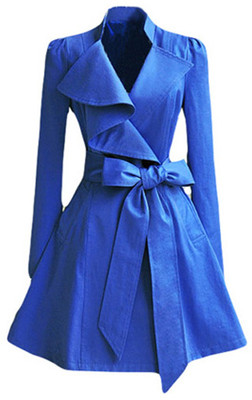

In [ ]:
outfit[0]

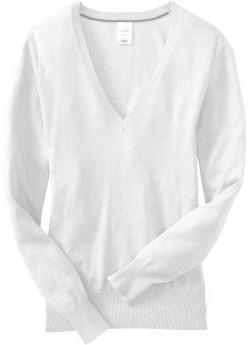

In [ ]:
outfit[1]

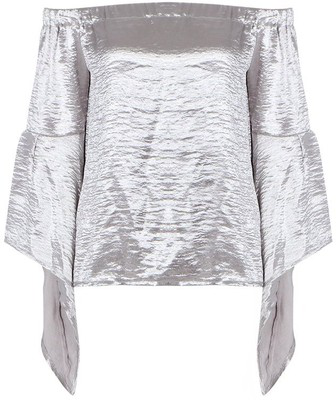

In [ ]:
outfit[2]

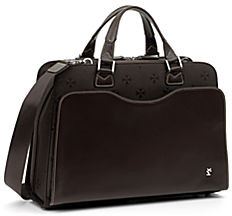

In [ ]:
outfit[3]

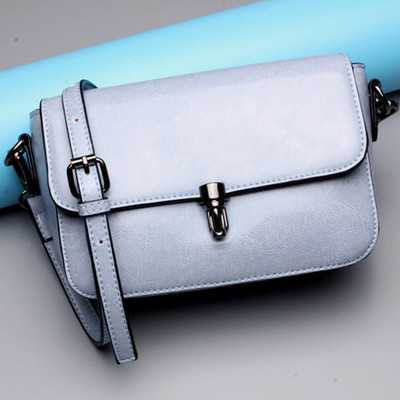

In [ ]:
outfit[4]

CACHE

In [ ]:
# image_ID_seq = [int(i) for i in run_set_inference(inputImageRNN, image_names, image_RNNs, (paramsF, paramsB))]

In [ ]:
# query_sets[0]

In [ ]:
# testImg_path = '/content/gdrive/MyDrive/Colab Notebooks/Capstone Project/Polyvore_Data/Outfits/119314458/7.jpg'

In [ ]:
# Image.open(testImg_path).show()

In [ ]:
# image = Image.open(testImg_path)

In [ ]:
# image_embedding_RNN, image_embedding_visualSemantic = test_features['119314458_6']
# image_embedding_RNN.shape

In [ ]:
# def RNN(batch_embedding):

#   sequence_length, batch_size = batch_embedding.shape[:-1]

#   batch_Input = jnp.reshape(batch_embedding, (sequence_length, batch_size, -1))
#   core = bi_lstm_fashion.LSTM_Model()
#   initial_state = core.initial_state(batch_size)

#   logits, _ = hk.dynamic_unroll(core, batch_Input, initial_state)

#   return logits

In [ ]:
# def RNN(image_embedding):
#   core = bi_lstm_fashion.LSTM_Model()

#   initial_state = core.initial_state(1)
#   logits, state = core(image_embedding, initial_state)

#   return logits, state

In [ ]:
# def RNN(image_embedding, initial_state):
#   batch = jnp.reshape(image_embedding, (1,-1))
#   core = bi_lstm_fashion.LSTM_Model()

#   if not(initial_state):
#     initial_state = core.initial_state(1)
  
#   logits, state = core(batch, initial_state)

#   return logits, state

In [ ]:
# rnn_model = hk.transform(RNN)

In [ ]:
# input = jnp.reshape(image_embedding_RNN, (1,-1))
# input.shape

In [ ]:
# total_loss_without_rng = hk.without_apply_rng(rnn_model)

# output_F = total_loss_without_rng.apply(params_F, image_embedding_RNN, None)
# # output_B = total_loss_without_rng.apply(params_B, image_embedding_RNN, 0.0)

In [ ]:
# a1, b1 = output_F
# a2, b2 = output_B

# a1.shape, a2.shape

In [ ]:
# output_F

In [ ]:
# def RNN(image_embedding):
#   sequence_length, batch_size = image_embedding.shape[:-1]

#   batch_Input = jnp.reshape(image_embedding, (sequence_length, batch_size, -1))

#   core = bi_lstm_fashion.LSTM_Model()

#   initial_state = core.initial_state(batch_size)

#   logits, _ = hk.dynamic_unroll(core, batch_Input, initial_state)

#   return logits

In [ ]:
# dfe = np.arange(4)
# dfe[-1] = 33
# dfe

In [ ]:
# params_tuple = list(params.items())

In [ ]:
# def ff():
#   return 2

# def dd(fn, d):
#   return(fn()+d)

# dd(ff, 6)

In [ ]:
# a = np.arange(6).reshape(2,3)
# b = a.reshape(-1)
# b

In [ ]:
# a = np.arange(6)

# a, a[::-1]

In [ ]:
# def run_RNN(rnn_cell_model, input_feed, test_feat, params_LSTM, exclusion_list):

#   res_set = []

#   logits, state = rnn_cell_model.apply(params_LSTM, input_feed, None)
  
#   for step in range(5):
#     # curr_score = jnp.exp(jnp.dot(logits, jnp.transpose(test_feat)))
#     curr_score = jnp.exp(jnp.dot(test_feat, logits.reshape(-1)))
#     curr_score /= jnp.sum(curr_score)

#     sorted_args = jnp.argsort(curr_score)[::-1]
    
#     next_image = sorted_args[0]

#     if next_image in exclusion_list:
#       next_image = sorted_args[1]

#     if next_image == test_feat.shape[0] - 1 or curr_score[-1] > 0.00001:
#       break
#     else:
#       input_feed = test_feat[next_image]
#       logits, state = rnn_cell_model.apply(params_LSTM, input_feed, state)
#       res_set.append(next_image)

#   return res_set

In [ ]:
# a = [2,1,4,3,9,5,1]

# a.remove(1)

# a

In [ ]:
# m = jnp.array([2,1,5,3,8])
# n = m.tolist()
# n, m

In [ ]:
# a = []

# if not(len(a)):
#   print('len 0')

In [ ]:
# a =  jnp.array([0.0,0.0,0.0])
# b = jnp.sum(a)

# not(b)

In [ ]:
a,b,c = 3,5,None

In [ ]:
a,b,c

(3, 5, None)

In [ ]:
# def main(input_images, input_caption, tokenDic, images_embedding_db, images_path, model_resnet, model_params):

#   img_embedding_params = (model_params['linear']['w'], model_params['visual_semantic']['wv'])
#   semantic_embedding_params = model_params['visual_semantic']['ws']
#   paramsF = {'lstm/linear': model_params['lstm/linear'],   'linear': model_params['linear_1']}
#   paramsB = {'lstm/linear': model_params['lstm_1/linear'], 'linear': model_params['linear_2']}

#   embeddings = [embeddingGenerator(img, imgSize, model_resnet, img_embedding_params) for img in input_images]
#   inputImageRNN = [embedding[0] for embedding in embeddings]
#   inputImageVS_unit = [embedding[1]/jnp.linalg.norm(embedding[1]) for embedding in embeddings]

#   image_names, image_RNNs, image_VSs = images_embedding_db
#   image_VSs_norm = jnp.reshape(jnp.linalg.norm(image_VSs, axis=1), (-1,1))
#   image_VSs_unit = image_VSs/image_VSs_norm

#   seqB, seqF, position = run_set_inference(inputImageRNN, image_names, image_RNNs, (paramsF, paramsB))
#   # mmm = run_set_inference(inputImageRNN, image_names, image_RNNs, (paramsF, paramsB))

#   if position:
#     if position == 'f':
#       4
#     if position == 'b':
#       6
#   else:
#     8


#   if input_caption != "":

#     # Calculate the word embedding
#     caption_OneHotEmbedding = captionProcessing(input_caption, tokenDic)
#     captions_Len = jnp.sum(caption_OneHotEmbedding)

#     if captions_Len:
#       caption_normalize = caption_OneHotEmbedding/captions_Len
#       caption_emb = jnp.dot(semantic_embedding_params, caption_normalize)
#       caption_emb_norm = jnp.linalg.norm(caption_emb)
#       caption_emb_unit = caption_emb/caption_emb_norm

#       seqB = [nearestNeighbour_search(i, image_VSs_unit, caption_emb_unit) for i in seqB]
#       seqF = [nearestNeighbour_search(i, image_VSs_unit, caption_emb_unit) for i in seqF]

#   outfit_B = fetch_seq(seqB, image_names, images_path)
#   outfit_F = fetch_seq(seqF, image_names, images_path)

#   outfit = outfit_B+[input_images[0]]+outfit_F

#   return outfit


In [ ]:
a = [1,2,3,4,5]
b = [2,5,7]

for i in b:
  if i in a:
    a.remove(i)

a

[1, 3, 4]